

*   정형 데이터 : csv/ 엑셀 같이 구조화 되어있는 DB
*   비정형 데이터 :구조화가 힘든 사진,텍스트등의 데이터



앙상블 학습 : 다수의 결정트리 모델을 결합하여 다수의 약 분류기를 이용해 하나의 강 분류기를 만들어내는 기법

*밑 사진은 기법중 하나인 Bagging을 이용한 랜덤포레스트 방식
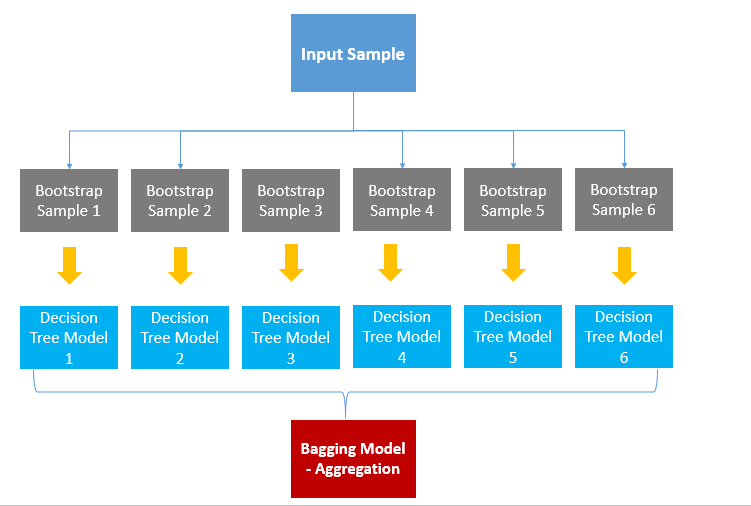

부트스트랩 ? 표본에서 복원추출 후 각 추출한 표본에 대한 통계량 재계산 (resampleing)
---
1.[n개의 표본에서 a번 복원추출 -> 뽑은 a개의 표본의 평균 계산]


2.[위 방식을 R(부트스트랩 반복횟수) 번 반복 -> 신뢰구간 제작]












**머신러닝에서의 부트스트랩? **
- 위에서 말한 개념같이 n개의 데이터가 있을때 n번 복원추출하여 부트스트랩 샘플 제작



### 1. 랜덤포레스트 
n개의 부트스트랩 샘플로 n개의 결정트리를 학습시켜서 최종 결과값을 예측 (BAGGING)
1. 분류 모델 : 각 tree가 예측한 값을 이용해 투표방식으로 결정
2. 회귀 모델 : 각 tree가 예측한 값을 이용해 평균을 구해 결정

특징 : 과대적합이 잘 발생하는 결정트리를 여러개로 만들어 과대적합을 극복함



### Bagging vs Boosting    --  앙상블 학습의 학습법



*   Bagging : 부트스트랩 샘플들을 이용해 다수의 결정트리를 만들어 최종결과를 예측
*   Boosting : 가중치를 이용하여 독립된 n개의 결정트리가 있을때, 첫번째 결정트리가 훈련시킨 모델의 데이터의 가중치를 두번째 결정트리에 넘겨주어 다음 트리에 영향을 주는 기법. 첫번째 모델에서 잘 분류한 데이터의 가중치는 낮게 수정하고, 잘못 분류한 데이터의 가중치는 높게 설정하여 넘겨줌


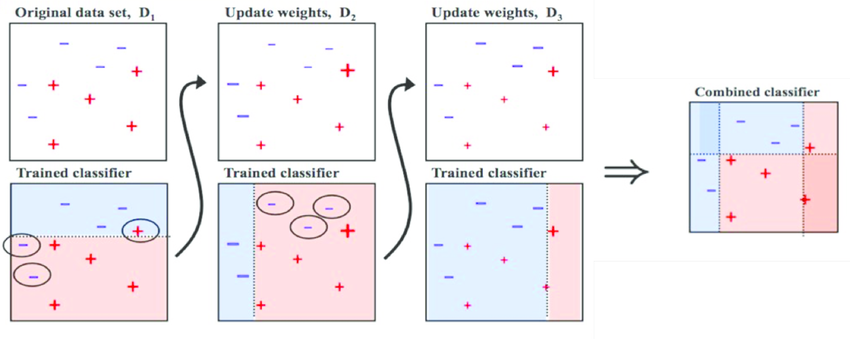





*   둘의 차이는 크게 병렬적과 순차적 으로 구분
*   과대적합 해결엔 Bagging, 개별 트리 성능 향상은 Boosting
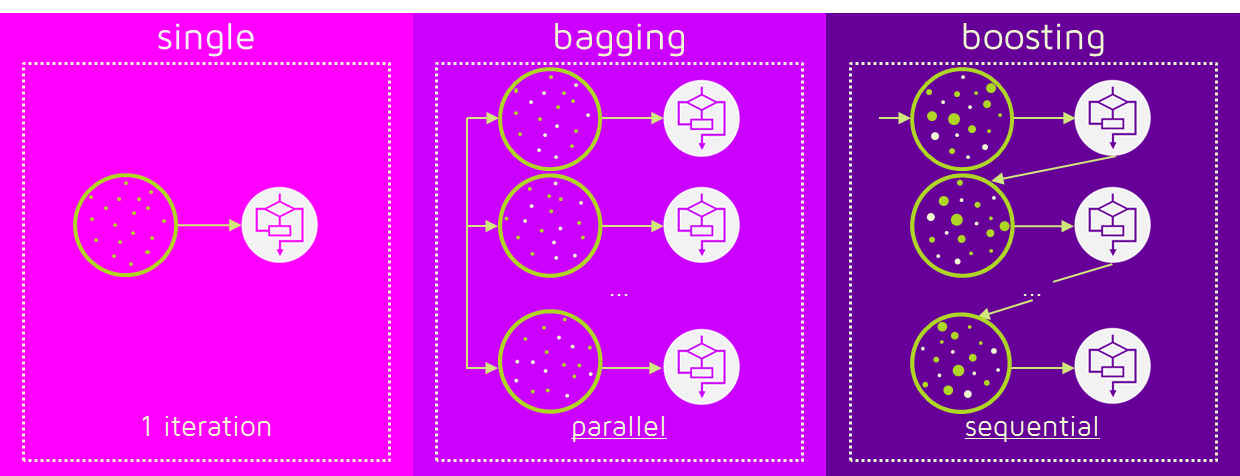



## *랜덤포레스트 코드

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
wine = pd.read_csv('https://bit.ly/wine-date')
data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs = -1, random_state = 42)

In [ ]:
scores = cross_validate(rf, train_input, train_target, return_train_score = True,n_jobs = -1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


In [ ]:
rf.fit(train_input,train_target)

print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


중요도 : 당도 > pH > 알코올 도수
중요도가 전장의 결정트리에서 바뀐이유 -> 다수의 트리를 특성을 랜덤으로 선택해서 훈련시키기에 하나의 특성에 집중되지 않음 -> 과대적합 방지, 일반화

In [ ]:
rf2 = RandomForestClassifier(oob_score =  True , n_jobs = -1, random_state = 42)
rf2.fit(train_input, train_target)
scores = cross_validate(rf2, train_input, train_target, return_train_score = True,n_jobs = -1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
print (rf2.score(test_input,test_target))
print(rf2.oob_score_)

0.9973541965122431 0.8905151032797809
0.8892307692307693
0.8934000384837406


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
params = {'n_estimators' : [10, 100],
          'min_impurity_decrease': uniform(0.0001,0.001),
          'max_depth':randint(20,50),
          'min_samples_split':randint(2,25),
          'min_samples_leaf':randint(1,25)}
gs =RandomizedSearchCV(RandomForestClassifier(random_state=42),params, n_iter = 100, n_jobs = -1, random_state = 42)
gs.fit(train_input, train_target)


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [ ]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))
Rff = gs.best_estimator_
print(Rff.score(test_input, test_target))

{'max_depth': 22, 'min_impurity_decrease': 0.00012058449429580245, 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 100}
0.8789709039757163
0.8692307692307693


### *엑스트라 트리 
다수의 결정트리를 각각 전체샘플을 이용해 훈련, 노드의 분할을 최선이 아닌 랜덤으로 행함.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_jobs = -1, random_state = 42)
scores = cross_validate(et,train_input, train_target,return_train_score= True , n_jobs= -1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
print(scores)

0.9974503966084433 0.8887848893166506
{'fit_time': array([0.47487712, 0.47342372, 0.4778645 , 0.47708845, 0.34159732]), 'score_time': array([0.10224223, 0.10241961, 0.10234594, 0.10256696, 0.10224199]), 'test_score': array([0.88365385, 0.87884615, 0.90375361, 0.88835419, 0.88931665]), 'train_score': array([0.9971133 , 0.99663219, 0.998076  , 0.997595  , 0.9978355 ])}


In [ ]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


In [ ]:
print(et.score(test_input,test_target))

0.8861538461538462


#### **부스팅**
### 그레이디언트 부스팅

깊이가 얇은 결정트리를 이용해 다음 트리의 오차를 보완하는 방법


*   default값은 트리 깊이가 3, estimate가 100
*   분류일때는 로지스틱 손실 함수 사용
*   회귀일때는 평균 제곱 오차 함수 사용


- 평균 제곱오차 함수 : 모델 출력값과 사용자가 원한 값의 차이를 제곱하여 더한것을 데이터의 수 만큼 나눠서 거리차이의 평균값을 구하는 함수, 제곱을 통해 값이 음수로 됬을때 오차가 줄어드는것을 방지하고, 어느 데이터에서 오차가 큰지 분별 가능

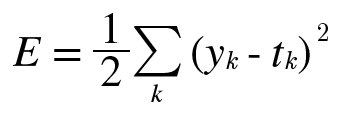






In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state = 42)
scores = cross_validate(gb,train_input, train_target,return_train_score= True , n_jobs= -1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
print(scores)

0.8881086892152563 0.8720430147331015
{'fit_time': array([0.47255707, 0.45835638, 0.4863739 , 0.49645066, 0.31668186]), 'score_time': array([0.003654  , 0.00366211, 0.0036757 , 0.00371599, 0.00298095]), 'test_score': array([0.86634615, 0.87019231, 0.89412897, 0.86044273, 0.86910491]), 'train_score': array([0.89006495, 0.88958383, 0.88239538, 0.89249639, 0.88600289])}


In [ ]:
gb = GradientBoostingClassifier(random_state = 42, n_estimators = 500, learning_rate= 0.2)
scores = cross_validate(gb,train_input, train_target,return_train_score= True , n_jobs= -1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
print(scores)

0.9464595437171814 0.8780082549788999
{'fit_time': array([2.33497858, 2.31143594, 2.3016808 , 2.26894498, 1.53635883]), 'score_time': array([0.01339889, 0.01282263, 0.01254249, 0.01285791, 0.00912952]), 'test_score': array([0.875     , 0.87211538, 0.89701636, 0.8719923 , 0.87391723]), 'train_score': array([0.9494828 , 0.94443108, 0.94468494, 0.94324194, 0.95045695])}


###그레이디언트 부스팅의 하이퍼 파라미터

1. learning_rate 학습률이란 0~1 사이의 수로, 결과 예측 값 계산에 사용
2. subsample  처음 weak learner가 학습에 사용할 데이터 비율

// (불확실) 첫번째 leaf에서 예측한 값은 전체 target의 평균 -> target과 평균의 차이를 반영한 트리 제작 (차이를 이용하여 target을 예측) -> 허나, 훈련 단계에서 차이와 평균의 값을 더하면 target의 값이 되므로 과대적합이 될 가능성이 크다 -> 따라서 차이에 학습률을 곱하여 과대적합을 방지함

-> 위 과정에서 구한 예측값으로 새로운 차이를 구해 새 트리를 제작
-> 반복





In [ ]:
gb.fit(train_input, train_target)
print(gb.feature_importances_)

[0.15872278 0.68010884 0.16116839]


### 히스토그램 기반 그레이디언트 부스팅 (아직 테스트 과정중)


*   미리 특성을 256구간으로 나누어 최적의 분할을 빠르게 찾을 수 있음
*   그레이디언트 부스팅보다 속도와 성능 향상



In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
hgb = HistGradientBoostingClassifier(random_state= 42)
scores = cross_validate(hgb,train_input, train_target,return_train_score= True , n_jobs= -1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
print(scores)

0.9321723946453317 0.8801241948619236
{'fit_time': array([0.51462579, 0.49474144, 0.51584888, 0.52780914, 0.28714681]), 'score_time': array([0.01128054, 0.01151037, 0.01119232, 0.0112431 , 0.0074203 ]), 'test_score': array([0.87115385, 0.88365385, 0.90279115, 0.86621752, 0.87680462]), 'train_score': array([0.93192206, 0.93216262, 0.92857143, 0.93265993, 0.93554594])}


###함수 permutaion_importance



*   특성을 랜덤하게 섞어 모델의 변화를 보고 특성의 중요도 계산
*   importances, importances_mean, importances_std 반환

*   모델 학습 후! 특정 특징을 섞었을때 모델 예측값 변화를 보고 특징 중요도 계산

*   랜덤이기에 매 시도마다 값이 바뀔수 있음



ex) 

*   섞은 후 성능이 낮아짐 -> 섞은 특징은 중요도가 높다
*   섞은 후 성능이 똑같거나 높아짐 -> 섞은 특징은 중요도가 낮다












In [ ]:
from sklearn.inspection import permutation_importance
hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target,n_repeats = 10, random_state = 42, n_jobs= -1)


AttributeError: ignored

In [ ]:
print(result.importances)

[[0.08793535 0.08350972 0.08908986 0.08312488 0.09274581 0.08755051
  0.08601116 0.09601693 0.09082163 0.09082163]
 [0.22782374 0.23590533 0.23936887 0.23436598 0.23725226 0.23436598
  0.23359631 0.23398114 0.23994612 0.22724649]
 [0.08581874 0.08601116 0.08062344 0.07504329 0.08427939 0.07792957
  0.07234943 0.07465846 0.08139311 0.08466423]]


In [ ]:
print(result.importances_mean)

[0.08876275 0.23438522 0.08027708]


In [ ]:
result = permutation_importance(hgb, test_input, test_target,n_repeats = 10, random_state = 42, n_jobs= -1)
print(result.importances_mean)
hgb.score(test_input, test_target)

[0.05969231 0.20238462 0.049     ]


0.8723076923076923

다양한 히스토그램기반 그레이디언트 부스팅 라이브러리
###XGBOOST 라이브러리

xgboost는 그레이디언트 부스팅 프레임워크로 tree 기반 학습 알고리즘, 병렬학습이 가능!

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method = 'hist', random_state = 42)
scores = cross_validate(xgb,train_input, train_target,return_train_score= True , n_jobs= -1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
print(scores)


0.8824322471423747 0.8726214185237284
{'fit_time': array([0.2245717 , 0.14586926, 0.1144402 , 0.10813284, 0.06768012]), 'score_time': array([0.0052135 , 0.00633788, 0.00635386, 0.01244068, 0.00394177]), 'test_score': array([0.86057692, 0.87115385, 0.89316651, 0.86236766, 0.87584216]), 'train_score': array([0.88669714, 0.87972095, 0.87782588, 0.88552189, 0.88239538])}


### LightGBM 라이브러리
그레이디언트 부스팅 프레임워크로 tree 기반 학습 알고리즘

xgboost나 gbm보다 속도와 성능이 좋음




*   다른 알고리즘은 수평적 증가에 비해 lightgbm은 수직적 증가가
*   적은 메모리를 차지하고 속도가 빠르지만, 작은 데이터에는 과적합 날 수 있음

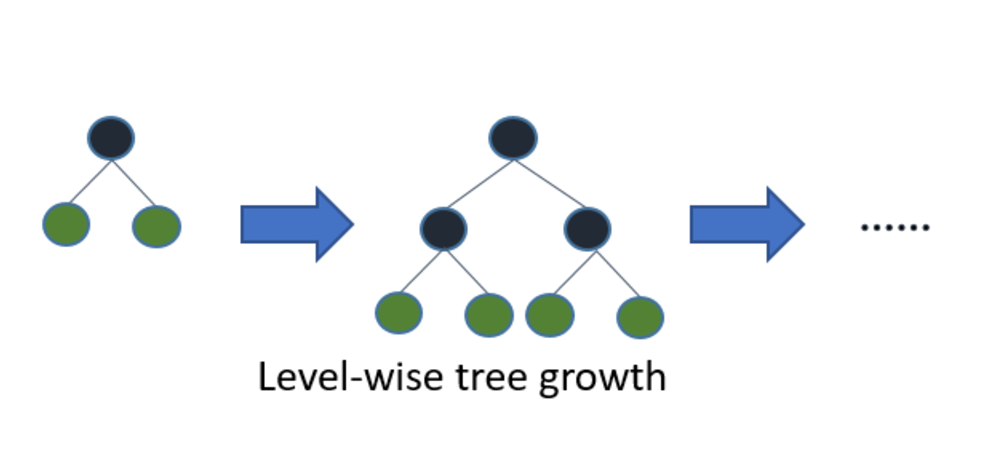


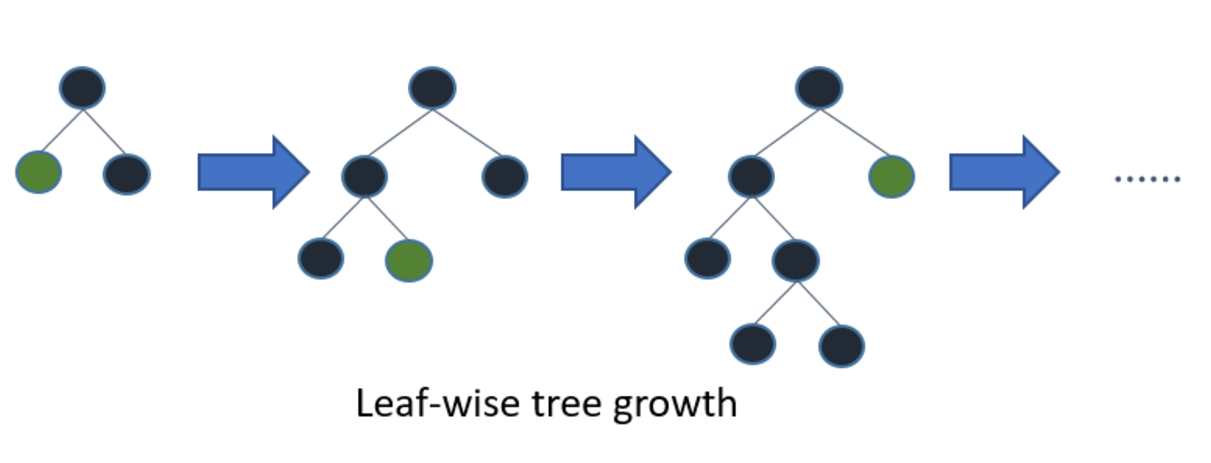

In [ ]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state = 42)
scores = cross_validate(lgb,train_input, train_target,return_train_score= True , n_jobs= -1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))
print(scores)



0.9338079582727165 0.8789710890649293
{'fit_time': array([0.1218257 , 0.11704803, 0.12446499, 0.12377429, 0.07568479]), 'score_time': array([0.0106616 , 0.01054406, 0.01057839, 0.01029444, 0.00772381]), 'test_score': array([0.86442308, 0.88076923, 0.90856593, 0.86429259, 0.87680462]), 'train_score': array([0.93312485, 0.93432764, 0.93217893, 0.93241943, 0.93698894])}
